In [53]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import math
import scipy.stats as stats
# from scipy.optimize import curve_fit

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import sklearn.preprocessing as prep
import sklearn.metrics as metrics
from sklearn import model_selection

from rfpimp import dropcol_importances
from rfpimp import importances

import pickle

## Helper Functions

#### Helper functions for plotting

In [187]:
def plot_bar_diagram(ax, data, nested=False, plots_labels=None, plots_colors=None, bar_labels='', width=0.4, 
                     trend_line=False, trend_order=1, trend_color=None, 
                     title='', length_label='', tick_labels='', tick_axis_label='',
                     orient='v', legend_loc=None, spines=None):
    """
    Plots single or multiple bar diagrams with data labels on top(aside) of the bars
    :param ax: matplotlib axes
    :param data: pandas DataFrame where rows correspond to bar plots and columns correspond to data labels (columns in data)
    :param nested: boolean. If True, bar plots are plotted on top of each other. If False bar plots are plotted besides each other
    :param bar_labels: pandas DataFrame. labels over the bars. Should be same shape as data
    :param width: float. Bar width
    :param title: string. Plot title
    :param length_label: bar height/width axis label
    :param spines: dictionary of booleans. indicates to plot borders or not. Keys=['left', 'right', 'top', 'bottom'], values=True/False
    :param orient: string. Bar orientation: 'v'-vertical; 'h'-horisontal
    """
    bars = list(data.index)
    cols = list(data.columns)
    cells = data.values.tolist()

    if bar_labels is not None:
        labels = []
        for i, lab in enumerate(bars):
            if bar_labels=='':
                labels.append([f"{j:.4f}" for j in cells[i]])
            else:
                labels.append(bar_labels[i])
#             labels = ([f"{j:.4f}" for j in cells[i]] if bar_labels=='' else bar_labels[i])

    if orient == 'v':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            color = ('r' if plots_colors is None else plots_colors[i])
            x = np.arange(len(cols))
            bar = ax.bar(x=x + width * (i - len(bars) / 2), height=cells[i], width=width,
                         label=label,
                         color=color,
                         align=('center' if nested else 'edge'))
            
            if trend_line:
                trend_color = (color if trend_color is None else trend_color[i])
                _x = np.arange(len(cols))
                _y = cells[i]
                _z = np.polyfit(_x, _y, trend_order)
                _p = np.poly1d(_z)
                trend = ax.plot(_x, _p(_x), color=color, linestyle='--', linewidth=2.5)
            
            if bar_labels is not None:
                autolabel(bar, ax, labels[i], oriented='v')

        ax.set_xticks(np.arange(len(cols)))
        if tick_labels=='':
            ax.set_xticklabels(cols)
        else:
            ax.set_xticklabels(tick_labels)
        if not length_label=='':
            ax.set_ylabel(length_label, fontsize=12, fontweight='bold')
        if not tick_axis_label=='':
            ax.set_xlabel(tick_axis_label, fontsize=12, fontweight='bold')
    elif orient == 'h':
        for i, lab in enumerate(bars):
            label = (bars[i] if plots_labels is None else plots_labels[i])
            y = np.arange(len(cols))
            height = width
            bar = ax.barh(y=y + height * (i - len(bars) / 2), width=cells[i], height=width,
                          label=label,
                          color=plots_colors[i],
                          align=('center' if nested else 'edge'))
            
            if trend_line:
                trend_color = (color if trend_color is None else trend_color[i])
                _x = np.arange(len(cols))
                _y = cells[i]
                _z = np.polyfit(_x, _y, trend_order)
                _p = np.poly1d(_z)
                trend = ax.plot(_x, _p(_x), color=color, linestyle='--', linewidth=2.5)
            
            if bar_labels is not None:
                autolabel(bar, ax, labels[i], oriented='v')
            if bar_labels is not None:
                autolabel(bar, ax, labels[i], oriented='h')

        ax.set_yticks(np.arange(len(cols)))
        if tick_labels=='':
            ax.set_yticklabels(cols)
        else:
            ax.set_yticklabels(tick_labels)
        if not length_label=='':
            ax.set_xlabel(length_label, fontsize=12, fontweight='bold')
        if not tick_axis_label=='':
            ax.set_ylabel(tick_axis_label, fontsize=12, fontweight='bold')
    else:
        raise ValueError('orient parameter value error. expected v or h ')

    if not title == '':
        ttl = ax.title
        ttl.set_position([.5, 1.07])
        ax.set_title(title, fontsize=14, fontweight='bold')
    if legend_loc is not None:
        ax.legend(loc=legend_loc)
    else:
        ax.legend().set_visible(False)

    if spines is None:
        spines = {'left': True,
                  'right': True,
                  'top': True,
                  'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])
        
    ax.grid(True, axis='y')

def autolabel(bars, ax, labels, oriented='v'):
    """Attach a text label displaying its height/width (depends of orientation)."""
    for bar, label in zip(bars, labels):
        if oriented == 'v':
            height = bar.get_height()
            ax.annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 2),
                        textcoords="offset points",
                        ha='center')
        else:
            width = bar.get_width()
            ax.annotate(label,
                        xy=(width, bar.get_y() + bar.get_height() / 2),
                        xytext=(1, 0),
                        textcoords="offset points",
                        ha='left',
                        va='center')

def plot_correlation_matrix(ax, data, cmap='hot', diagonal=False, square=True, annotate=False, annot_kwargs=8):
    mask = None
    if diagonal:
        mask = np.zeros_like(data, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax,
                mask=mask,
                square=square,
                linewidths=1.5,
                cmap=cmap,
                cbar_kws={'shrink': 1, 'ticks': [-1, -.5, 0, 0.5, 1]},
                vmin=-1,
                vmax=1,
                annot=annotate,
                annot_kws={'size': annot_kwargs})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    
def plot_confusion_matrix(model, X, y, ax, normalize=True, title=None):
    """Plots confusion matrix
    Parameters:
    ax =  matplotlib axes
    normalyze = normalization over truth (number_predicted / total_count_of_this_class)
    """
    model.fit(X,y)
    conf_matrix = metrics.confusion_matrix(y_true=y, y_pred=model.predict(X),
                              labels=None)  # returns matrix for sorted classes (i.e 0, 1, 2,..., n)
    classes = y.unique()
    classes.sort()
    n_classes = [len(y[y == c]) for c in classes]
    if normalize == True:
        n_matrix = [[i for j in range(len(n_classes))] for i in n_classes]
        norm_matrix = conf_matrix / np.array(n_classes)
        ns_matrix = np.array([[i for j in enumerate(n_classes)] for i in n_classes])
        labels = np.array([["{0:.2%} \n {1:d} of {2:d}".format(norm_matrix[i, j], conf_matrix[i, j],
                                                               ns_matrix[i, j]) for j, v in
                            enumerate(norm_matrix[i])]
                           for i, v in enumerate(norm_matrix)])

        sns.heatmap(norm_matrix, annot=labels, fmt='', cmap='Blues')
    else:
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

    ax.set_ylabel('True Labels')
    ax.set_xlabel('Predicted Labels')
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title)
    ttl = ax.title
    ttl.set_position([.5, 1.07])

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = ax.get_ylim()  # discover the values for bottom and top
    b += 0.5  # Add 0.5 to the bottom
    t -= 0.5  # Subtract 0.5 from the top
    ax.set_ylim(b, t)  # update the ylim(bottom, top) values
    
def plot_mae_deciles(model, X, y_true, y_bl, index, ax, log_transform=False, cumulative=False, title=None, exp=True):
    if exp==True:
        y_pred = np.exp(model.predict(X)) - 1
        y_true = np.exp(y_true.values) - 1
        y_bl = np.exp(y_bl.values) - 1
    else:
        y_pred = model.predict(X)
    y_mae_model = np.abs(y_true - y_pred)
    y_mae_naive = np.abs(y_true - np.mean(y_bl))
    y = np.stack([y_mae_model, y_mae_naive], axis=1)
    y = pd.DataFrame(y, index=index, columns=['mae_model', 'mae_naive']).sort_values(by='mae_model', ascending=True)

    y_dec = np.zeros(len(y_true))
    n = len(y) // 10
    N = 10 * n
    for i in range(0, N, n):
        if i/n==9:
            y_dec[i:] = i/n
        else:
            y_dec[i:i+n] = i/n
    y['deciles'] = y_dec
    y['deciles'] = y['deciles'].astype('int32')

    mae_model = []
    mae_naive = []
    dec_labs = y['deciles'].unique()
    ax.set_xticks(np.arange(len(dec_labs)))
    for i in dec_labs:
        if cumulative:
            mae_model.append(np.mean(y.loc[y['deciles']<=i, 'mae_model']))
            mae_naive.append(np.mean(y.loc[y['deciles']<=i, 'mae_naive']))
            ax.set_xticklabels(np.arange(10,110,10))
            ax.set_xlabel('% of population')
            ax.set_ylabel('Mean absolute error \n (cumulative mean)')
        else:
            mae_model.append(np.mean(y.loc[y['deciles']==i, 'mae_model']))
            mae_naive.append(np.mean(y.loc[y['deciles']==i, 'mae_naive']))
            ax.set_xlabel('Deciles')
            ax.set_ylabel('Mean absolute error \n (mean per decile)')
    data = np.stack([mae_model, mae_naive], axis=1)
    data = pd.DataFrame(data, columns=['mae_model', 'mae_naive'])

    _x = data.index
    _y = data['mae_model'].values
    ax.plot(_x, _y, marker='o', color='b')
    
    _y = data['mae_naive']
    ax.plot(_x, _y, marker='o', color='r')
    
    ax.legend(['Model predictions', 'Naive predictions'])
    spines = {'left': True,
              'right': False,
              'top': False,
              'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])
        
    if log_transform:
        ax.set_yscale('log')
    
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title)
    ttl = ax.title
    ttl.set_position([.5, 1.05])
    
    ax.grid(True)
                 
    deciles = y['deciles']
    if index is not None:
        deciles.index = index
        
    return data, deciles

def plot_sale_change_deciles(model, X, y_true, y_bl, index, ax, cumulative=False, title=None, colors=None, exp=True):
    if exp==True:
        y_pred = np.exp(model.predict(X)) - 1
        y_true = np.exp(y_true.values) - 1
    else:
        y_pred = model.predict(X)
    y_bl = np.exp(y_bl.values) - 1
    
    sale_change_pred = y_pred - y_bl
    sale_change_true = y_true - y_bl
    y = np.stack([sale_change_pred, sale_change_true], axis=1)
    y = pd.DataFrame(y, index=index, columns=['sale_change_pred', 'sale_change_true']).sort_values(by='sale_change_pred', ascending=False)

    y_dec = np.zeros(len(y_true))
    n = len(y) // 10
    N = 10 * n
    for i in range(0, N, n):
        if i/n==9:
            y_dec[i:] = i/n
        else:
            y_dec[i:i+n] = i/n
    y['deciles'] = y_dec
    y['deciles'] = y['deciles'].astype('int32')

    sale_change_pred = []
    sale_change_true = []
    dec_labs = y['deciles'].unique()
    ax.set_xticks(np.arange(len(dec_labs)))
    for i in dec_labs:
        if cumulative:
            sale_change_pred.append(np.mean(y.loc[y['deciles']<=i, 'sale_change_pred']))
            sale_change_true.append(np.mean(y.loc[y['deciles']<=i, 'sale_change_true']))
            ax.set_xticklabels(np.arange(10,110,10))
            ax.set_xlabel('% of population', fontsize=12, fontweight='bold')
            ax.set_ylabel('Sales change \n (mean per % of population)', fontsize=12, fontweight='bold')
        else:
            sale_change_pred.append(np.mean(y.loc[y['deciles']==i, 'sale_change_pred']))
            sale_change_true.append(np.mean(y.loc[y['deciles']==i, 'sale_change_true']))
            ax.set_xlabel('Deciles', fontsize=12, fontweight='bold')
            ax.set_ylabel('Sales change per advisor', fontsize=12, fontweight='bold')
    data = np.stack([sale_change_pred, sale_change_true], axis=1)
    data = pd.DataFrame(data, columns=['sale_change_pred', 'sale_change_true'])

    _x = data.index
    _y = data['sale_change_pred'].values
    ax.plot(_x, _y, marker='o', color=('tab:blue' if colors is None else colors[0]))
    
    _y = data['sale_change_true']
    ax.plot(_x, _y, marker='o', color=('tab:orange' if colors is None else colors[0]))
    
    ax.legend(['Predicted sales change', 'True sales change'])
    spines = {'left': True,
              'right': False,
              'top': False,
              'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])
    
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title, fontsize=14, fontweight='bold')
    ttl = ax.title
    ttl.set_position([.5, 1.05])
    
    ax.grid(True)
                 
    deciles = y['deciles']
    if index is not None:
        deciles.index = index
        
    return data, deciles

def plot_sales_deciles(model, X, y_true, index, ax, cumulative=False, log_transform=False, title=None, colors=None, exp=True):
    if exp==True:
        y_pred = np.exp(model.predict(X)) - 1
        y_true = np.exp(y_true.values) - 1
    else:
        y_pred = model.predict(X)
    y = np.stack([y_pred, y_true], axis=1)
    y = pd.DataFrame(y, index=index, columns=['sales_pred', 'sales_true']).sort_values(by='sales_pred', ascending=False)

    y_dec = np.zeros(len(y_true))
    n = len(y) // 10
    N = 10 * n
    for i in range(0, N, n):
        if i/n==9:
            y_dec[i:] = i/n
        else:
            y_dec[i:i+n] = i/n
    y['deciles'] = y_dec
    y['deciles'] = y['deciles'].astype('int32')

    sales_pred = []
    sales_true = []
    dec_labs = y['deciles'].unique()
    ax.set_xticks(np.arange(len(dec_labs)))
    for i in dec_labs:
        if cumulative:
            sales_pred.append(np.mean(y.loc[y['deciles']<=i, 'sales_pred']))
            sales_true.append(np.mean(y.loc[y['deciles']<=i, 'sales_true']))
            ax.set_xticklabels(np.arange(10,110,10))
            ax.set_xlabel('% of population', fontsize=12, fontweight='bold')
            ax.set_ylabel('Sales \n (mean per % of population)', fontsize=12, fontweight='bold')
        else:
            sales_pred.append(np.mean(y.loc[y['deciles']==i, 'sales_pred']))
            sales_true.append(np.mean(y.loc[y['deciles']==i, 'sales_true']))
            ax.set_xlabel('Deciles', fontsize=12, fontweight='bold')
            ax.set_ylabel('Sales per advisor', fontsize=12, fontweight='bold')
    data = np.stack([sales_pred, sales_true], axis=1)
    data = pd.DataFrame(data, columns=['sales_pred', 'sales_true'])

    _x = data.index
    _y = data['sales_pred'].values
    ax.plot(_x, _y, marker='o', color=('tab:blue' if colors is None else colors[0]))
    
    _y = data['sales_true']
    ax.plot(_x, _y, marker='o', color=('tab:orange' if colors is None else colors[0]))
    
    if log_transform:
        ax.set_yscale('log')
    
    ax.legend(['Predicted sales', 'True sales'])
    spines = {'left': True,
              'right': False,
              'top': False,
              'bottom': True}
    for i in list(spines.keys()):
        ax.spines[i].set_visible(spines[i])
    
    if title is None:
        title = model.__class__.__name__
    ax.set_title(title, fontsize=14, fontweight='bold')
    ttl = ax.title
    ttl.set_position([.5, 1.05])
    
    ax.grid(True)
                 
    deciles = y['deciles']
    if index is not None:
        deciles.index = index
        
    return data, deciles

def plot_deciles_data(data, figname='', color='dimgrey', plot_type='bar', trend_line=False, trend_order=1, trend_color='dimgrey', cumulative_pop=False, data_labels=False, x_label=None, y_label=None):
    grd = list(data.columns)
    grd_n = len(grd)
    grd_cols_n = 2
    grd_rows_n = int(math.ceil(grd_n / grd_cols_n))

    plt_h = 4
    plt_w = 12
    
    fig_ttl = plt.figure()
    fig_ttl.set_size_inches(plt_w * grd_cols_n, 0.3)
    ax0 = fig_ttl.add_subplot()
    ax0.text(0.5, 0.5, figname, fontsize=18, horizontalalignment='center', verticalalignment='center')
    ax0.axis('off')

    fig = plt.figure()
    fig.set_size_inches(plt_w * grd_cols_n, plt_h * grd_rows_n)
    gs = gridspec.GridSpec(grd_rows_n, grd_cols_n, figure=fig, wspace=0.3, hspace=0.5)

    for idx, col in enumerate(list(data.columns)):
        if data_labels:
            labs = ['{0:.2f}'.format(i) for i in data[col]]
            bar_labels=[labs]
        else:
            bar_labels=None
        
        if cumulative_pop:
            tick_labels = np.arange(10,110,10)
        else:
            tick_labels = list(data.index)
        
        if x_label is not None:
            tick_axis_label = x_label
        else:
            tick_axis_label = ''
        if y_label is not None:
            length_label = y_label
        else:
            length_label = col
        
        if plot_type=='bar':
            plot_bar_diagram(ax=fig.add_subplot(gs[idx]),
                             data=data[col].to_frame().T,
                             bar_labels=bar_labels,
                             tick_labels = tick_labels,
                             plots_labels=None,
                             plots_colors=[color],
                             width=0.3,
                             trend_line=trend_line, 
                             trend_order=trend_order, 
                             trend_color=[trend_color],
                             title=None,
                             tick_axis_label=tick_axis_label,
                             length_label=length_label,
                             orient='v',
                             spines={'top': False, 'right': False})
        elif plot_type=='scatter':
            ax=fig.add_subplot(gs[idx])
            _x = tick_labels
            _y = data[col].values
            ax.scatter(_x, _y, marker='o', color=color)
            z = np.polyfit(_x, _y, 2)
            p = np.poly1d(z)
            ax.plot(_x, p(_x), color=color)
            
def plot_diagram_xy(data, x, y, ax, x_title=None, y_title=None, x_labels_format='{0:.0f}', title=None, pot_size=None, tick_labelsIprefix=''):
    _data = data.copy()
    _data = _data.sort_values(by=x, ascending=False)
    _data['deciles'] = pd.cut(_data[x], 10, labels=False, duplicates='drop')
#     _dec = np.zeros(len(_data[x]))
#     n = len(_data[x]) // 10
#     N = 10 * n
#     for i in range(0, N, n):
#         if i/n==9:
#             _dec[i:] = i/n
#         else:
#             _dec[i:i+n] = i/n
#     _data['deciles'] = _dec
#     _data['deciles'] = _data['deciles'].astype('int32')

    cuts = _data['deciles'].unique()
    _x = np.zeros(len(cuts))
    _y = np.zeros(len(cuts))
    for idx, i in enumerate(cuts):
        _x[len(cuts)-1-idx] = np.mean(_data.loc[_data['deciles']==i, x])
        _y[len(cuts)-1-idx] = np.mean(_data.loc[_data['deciles']==i, y])
#     cuts = _data['deciles'].unique()
#     _x = np.zeros(len(cuts))
#     _y = np.zeros(len(cuts))
#     for idx, i in enumerate(cuts):
#         _x[len(cuts)-1-idx] = np.mean(_data.loc[_data['deciles']==i, x])
#         _y[len(cuts)-1-idx] = np.mean(_data.loc[_data['deciles']==i, y])
    plot_bar_diagram(ax=ax,
                     data=pd.Series(_y).to_frame().T,
                     tick_labels=[tick_labelsIprefix + x_labels_format.format(i) for i in _x],
                     bar_labels=None,
                     orient='v',
                     width=0.3,
                     title=('{0} vs {1}'.format(y,x) if title is None else title),
                     length_label=(y if y_title is None else y_title),
                     tick_axis_label=(x if x_title is None else x_title),
                     plots_colors=['tab:blue'],
                     spines={'top': False, 'right': False})
    
def plot_diagram_deciles(data, y, ax, x_title=None, y_title=None, title=None, pot_size=None):
    _data = data.copy()
    dec_labs = _data['deciles'].unique()
    dec_mean = []
    for i in dec_labs:
        dec_samples = _data.loc[_data['deciles']==i]
        n = len(dec_samples)
        val_mean = np.mean(dec_samples[y])
        dec_mean.append(val_mean)
        
    plot_bar_diagram(ax=ax,
                     data=pd.Series(dec_mean).to_frame().T,
                     tick_labels=[i for i in dec_labs],
                     bar_labels=None,
                     orient='v',
                     width=0.3,
                     title=('{0} vs {1}'.format(y,x) if title is None else title),
                     length_label=(y if y_title is None else y_title),
                     tick_axis_label=('Deciles' if x_title is None else x_title),
                     plots_colors=['tab:blue'],
                     spines={'top': False, 'right': False})
    
def get_lift_chart(model, data, X, by_class=1, exp=True):
    _data = data.copy()
    if exp==True:
        y_pred = np.exp(model.predict(X)) - 1
#         y_true = np.exp(y_true.values) - 1
    else:
        y_pred = model.predict(X)
#     y = np.stack([y_true, y_pred], axis=1)
#     y = pd.DataFrame(y, columns=['true_y', 'predicted_y']).sort_values(by='predicted_y', ascending=False)
    _data['predicted_y'] = y_pred.reshape(-1,1)
#     y = pd.DataFrame(y_pred.reshape(-1,1), columns=['predicted_y']).sort_values(by='predicted_y', ascending=False)
    y = _data.sort_values(by='predicted_y', ascending=False)
    y_dec = np.zeros(len(y))
    n = len(y) // 10
    N = 10 * n
    for i in range(0, N, n):
        if i/n==9:
            y_dec[i:] = i/n
        else:
            y_dec[i:i+n] = i/n
    y['deciles'] = y_dec
    y['deciles'] = y['deciles'].astype('int32')

    def val_cum(arr_n, arr_val, pos):
        arr = []
        for i in range(pos + 1):
#             print(arr_val[i], arr_n[i])
            arr.append(arr_val[i] * arr_n[i])
        return np.sum(arr)

    dec_labs = y['deciles'].unique()
    total_mean = np.mean(y['predicted_y'])
#     total_mean = np.sum(y['true_y']) / len(y)
    n_samples = []
    dec_mean = []
#     dec_val_per_fa = []
    dec_lift_ovr_mean = []
    n_cum_samples = []
    cum_mean = []
#     cum_val_per_fa = []
    cum_lift_ovr_mean = []
    for i in dec_labs:
        dec_samples = y.loc[y['deciles']==i]

        n = len(dec_samples)
        val_mean = np.mean(dec_samples['predicted_y'])
#         val_sum = np.sum(dec_samples['predicted_y'])
#         val_per_fa = val_sum / n
        lift_ovr = val_mean / total_mean - 1
#         lift_ovr = val_per_fa / total_mean - 1

        n_samples.append(n)
        dec_mean.append(val_mean)
#         dec_val_per_fa.append(val_per_fa)
        dec_lift_ovr_mean.append(lift_ovr)

        n_cum = len(y.loc[y['deciles']<=i])
#         mean_cum = (val_mean if i==0 else val_cum(n_samples, dec_mean, i) / n_cum)
        mean_cum = np.sum(dec_mean)
#         val_per_fa_cum = np.sum(dec_val_per_fa)
        lift_ovr_cum = mean_cum / total_mean - 1
#         lift_ovr_cum = val_per_fa_cum / total_mean - 1

        n_cum_samples.append(n_cum)
        cum_mean.append(mean_cum)
#         cum_val_per_fa.append(val_per_fa_cum)
#         cum_lift_ovr_mean.append(lift_ovr_cum)
        cum_lift_ovr_mean.append(np.sum(dec_lift_ovr_mean))
    lift = np.stack([n_samples, dec_mean, dec_lift_ovr_mean, n_cum_samples, cum_mean, cum_lift_ovr_mean], axis=1)
    return y, total_mean, pd.DataFrame(lift, columns=['n_samples', 'dec_mean', 'dec_lift_ovr_mean', 'n_cum_samples', 'cum_mean', 'cum_lift_ovr_mean'])
#     lift = np.stack([n_samples, dec_val_per_fa, dec_lift_ovr_mean, n_cum_samples, cum_val_per_fa, cum_lift_ovr_mean], axis=1)
#     return total_mean, pd.DataFrame(lift, columns=['n_samples', 'dec_val_per_fa', 'dec_lift_ovr_mean', 'n_cum_samples', 'cum_val_per_fa', 'cum_lift_ovr_mean'])

#### Helper functions for model training

In [55]:
# Tune parameters
def param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=''):
    if refit == '': refit = list(scoring.keys())[0]
    gsearch = model_selection.GridSearchCV(estimator=model, param_grid=param_ranges, scoring=scoring, cv=cv, refit=refit, return_train_score=True,
                           n_jobs=-1)
    gsearch.fit(X_train, y_train)
    cv_res = pd.DataFrame(gsearch.cv_results_)
    cv_res_sel = []
    for i in list(scoring.keys()):
        df = cv_res.loc[cv_res['rank_test_%s' % i] == 1].head(1)
        cv_res_sel.append(df[['mean_train_%s' % i, 'std_train_%s' % i, 'mean_test_%s' % i, 'std_test_%s' % i]].values[0])

    cv_res_sel = pd.DataFrame(cv_res_sel, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_res_sel.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return gsearch.best_estimator_, gsearch.best_params_, gsearch.best_score_, cv_results

# Cross-validation report
def cv_rep(model, X, y, cv, scoring, fit_params=None):
    cv_res = model_selection.cross_validate(model, X, y, scoring=scoring, cv=cv, return_train_score=True, fit_params=fit_params, n_jobs=-1)
    cv_res = [[np.mean(cv_res['train_%s' % i]), np.std(cv_res['train_%s' % i]), np.mean(cv_res['test_%s' % i]), np.std(cv_res['test_%s' % i])] for i in list(scoring.keys())]
    cv_results = pd.DataFrame(cv_res, index=list(scoring.keys()), columns=['mean_train', 'std_train', 'mean_test', 'std_test'])
    cv_results = cv_results.T
    cv_results = cv_results.apply(lambda i: np.absolute(i))
    return cv_results

# Tune model parameters and print CV report
def train_best_model(model, param_ranges, X_train, y_train, scoring, cv, refit):
    model, best_params, best_score, cv_res = param_tune(model, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print('CV results \n ===================================================')
    display(cv_res)
    print('\n Best parameters: ', best_params)
    return model, cv_res

# Tune model parameters and print CV report for calibrated classifier model
def train_best_model_cal(model, param_ranges, X_train, y_train, scoring, cv, refit):
    if model.__class__.__name__=='CalibratedClassifierCV':
         model_cal= model 
    else:
        model_cal = calib.CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv=cv)
    model_cal, best_params, best_score, cv_res = param_tune(model_cal, X_train, y_train, param_ranges, scoring, cv, refit=refit)
    print(cv_res)
    print(best_params)
    return model, cv_res

def dropcol_imp_r2_metric(model, X_valid, y_valid, sample_weights):
    y_pred = model.predict(X_valid)
    return metrics.r2_score(y_valid, y_pred, sample_weight=sample_weights)

#### Load data

In [56]:
data_2018 = pd.read_excel(io='Data/Transaction Data.xlsx',
                     sheet_name='Transactions18',
                     header=0,
                     index_col=0,
                     verbose=1)

Reading sheet Transactions18


In [57]:
data_2019 = pd.read_excel(io='Data/Transaction Data.xlsx',
                     sheet_name='Transactions19',
                     header=0,
                     index_col=0,
                     verbose=1)

Reading sheet Transactions19


#### Drop refresh date column

In [58]:
data_2018 = data_2018.drop(columns=['refresh_date'])

In [59]:
data_2019 = data_2019.drop(columns=['refresh_date'])

#### Add target columns

In [60]:
data_2019.columns = [i + '_target' for i in list(data_2019.columns)]

In [61]:
data_2019 = data_2019.loc[data_2018.index]

In [62]:
data = pd.concat([data_2018, data_2019], axis=1)

#### Deal with NaNs

All data is numeric and and naturaly is equal or more than zero. So will fill nans with zeros.

In [63]:
data = data.fillna(value=0)

#### Drop samples that have negative sales and positive redemptions

In [64]:
# Inspect positive variables
f_pos = ['sales_12M_target',
         'AUM', 
         'sales_curr',         
         'sales_12M',
         'aum_AC_EQUITY',
         'aum_AC_FIXED_INCOME_MUNI',
         'aum_AC_FIXED_INCOME_TAXABLE',
         'aum_AC_MULTIPLE',
         'aum_AC_PHYSICAL_COMMODITY',
         'aum_AC_REAL_ESTATE',
         'aum_AC_TARGET',
         'aum_P_529',
         'aum_P_ETF',
         'aum_P_MF',
         'aum_P_SMA',
         'aum_P_UCITS',
         'aum_P_UIT']

for i in f_pos:
    print(i, len(data.loc[data[i] < 0]))

sales_12M_target 2
AUM 4377
sales_curr 4
sales_12M 7
aum_AC_EQUITY 3871
aum_AC_FIXED_INCOME_MUNI 3276
aum_AC_FIXED_INCOME_TAXABLE 1694
aum_AC_MULTIPLE 1149
aum_AC_PHYSICAL_COMMODITY 90
aum_AC_REAL_ESTATE 3
aum_AC_TARGET 19
aum_P_529 14
aum_P_ETF 5
aum_P_MF 4564
aum_P_SMA 1151
aum_P_UCITS 15
aum_P_UIT 42


In [65]:
# Inspect negative variables
f_neg = ['redemption_curr',
'redemption_12M']

for i in f_neg:
    print(i, len(data.loc[data[i] > 0]))

redemption_curr 3
redemption_12M 4


In [66]:
data = data.loc[(data['sales_12M']>=0) & 
         (data['sales_12M_target']>=0) & 
         (data['sales_curr']>=0) & 
         (data['redemption_curr']<=0) & 
         (data['redemption_12M']<=0)]

#### Reverse redemptions sign

In [67]:
for i in f_neg:
    data[i] = data[i].apply(np.abs)

#### Add delta_sales = sales_12M_2019 - sales_12M_2018

In [68]:
data['delta_sales_12M_18_19'] = (data['sales_12M_target'] - data['sales_12M'])

#### Add net sales data (net_sales = sales - redumptions)

In [69]:
net_cols = {'net_no_of_sales_12M_1': ['no_of_sales_12M_1', 'no_of_Redemption_12M_1'], 
            'net_no_of_sales_12M_10K': ['no_of_sales_12M_10K', 'no_of_Redemption_12M_10K'], 
            'net_no_of_funds_sold_12M_1': ['no_of_funds_sold_12M_1', 'no_of_funds_redeemed_12M_1'], 
            'net_no_of_fund_sales_12M_10K': ['no_of_fund_sales_12M_10K', 'no_of_funds_Redemption_12M_10K'], 
            'net_no_of_assetclass_sold_12M_1': ['no_of_assetclass_sold_12M_1', 'no_of_assetclass_redeemed_12M_1'], 
            'net_no_of_assetclass_sales_12M_10K': ['no_of_assetclass_sales_12M_10K', 'no_of_assetclass_Redemption_12M_10K']}

In [70]:
for net_col in net_cols.keys():
    data[net_col] = data[net_cols[net_col][0]] - data[net_cols[net_col][1]]

In [71]:
data['net_sales_curr'] = data['sales_curr'] - data['redemption_curr']
data['net_sales_12M'] = data['sales_12M'] - data['redemption_12M']

#### Split aum columns into positive and negative columns

In [72]:
aum_cols = []
for i in list(data.columns):
    if 'aum' in i:
        aum_cols.append(i)

In [73]:
for aum_col in aum_cols:
    data['pos_' + aum_col] = data[aum_col].apply(lambda x: x if x >= 0 else 0)
    data['neg_' + aum_col] = data[aum_col].apply(lambda x: np.abs(x) if x < 0 else 0)

In [74]:
data['pos_AUM'] = data['AUM'].apply(lambda x: x if x >= 0 else 0)
data['neg_AUM'] = data['AUM'].apply(lambda x: np.abs(x) if x < 0 else 0)

#### Split net columns into positive and negative columns

In [75]:
for net_col in list(net_cols.keys()) + ['net_sales_curr', 'net_sales_12M']:
    data['pos_' + net_col] = data[net_col].apply(lambda x: x if x >= 0 else 0)
    data['neg_' + net_col] = data[net_col].apply(lambda x: np.abs(x) if x < 0 else 0)

#### Make a copy of data for post-processing

In [76]:
data_raw = data.copy()

#### Apply log-transform to continuous features

In [77]:
# Drop columns that have negative values
data = data.drop(columns=aum_cols)
data = data.drop(columns=['AUM'])
data = data.drop(columns=list(net_cols.keys()) + ['net_sales_curr', 'net_sales_12M'])

In [78]:
for i in ['sales_curr',
          'sales_12M',
          'redemption_curr',
          'redemption_12M',
          'pos_aum_AC_EQUITY',
          'neg_aum_AC_EQUITY',
          'pos_aum_AC_FIXED_INCOME_MUNI',
          'neg_aum_AC_FIXED_INCOME_MUNI',
          'pos_aum_AC_FIXED_INCOME_TAXABLE',
          'neg_aum_AC_FIXED_INCOME_TAXABLE',
          'pos_aum_AC_MONEY',
          'neg_aum_AC_MONEY',
          'pos_aum_AC_MULTIPLE',
          'neg_aum_AC_MULTIPLE',
          'pos_aum_AC_PHYSICAL_COMMODITY',
          'neg_aum_AC_PHYSICAL_COMMODITY',
          'pos_aum_AC_REAL_ESTATE',
          'neg_aum_AC_REAL_ESTATE',
          'pos_aum_AC_TARGET',
          'neg_aum_AC_TARGET',
          'pos_aum_P_529',
          'neg_aum_P_529',
          'pos_aum_P_ALT',
          'neg_aum_P_ALT',
          'pos_aum_P_CEF',
          'neg_aum_P_CEF',
          'pos_aum_P_ETF',
          'neg_aum_P_ETF',
          'pos_aum_P_MF',
          'neg_aum_P_MF',
          'pos_aum_P_SMA',
          'neg_aum_P_SMA',
          'pos_aum_P_UCITS',
          'neg_aum_P_UCITS',
          'pos_aum_P_UIT',
          'neg_aum_P_UIT',
          'pos_net_sales_curr',
          'pos_net_sales_12M',
          'neg_net_sales_curr',
          'neg_net_sales_12M']:
    data[i] = data[i].apply(lambda x: np.log(x+1))

#### Data summary

In [79]:
data_cols = ['sales_12M_target', 'new_Fund_added_12M_target']

In [80]:
for col in list(data.columns):
    if not col in data_cols:
        data_cols.append(col)

In [81]:
data = data[data_cols]

In [82]:
data_desc = data.describe().T
data_desc

,count,mean,std,min,25%,50%,75%,max
sales_12M_target,9988.0,211519.205077,1.139872e+06,0.0,0.0,87.575,45143.376250,4.867638e+07
new_Fund_added_12M_target,9988.0,0.432119,1.097845e+00,0.0,0.0,0.000,1.000000,2.000000e+01
no_of_sales_12M_1,9988.0,20.049760,9.849246e+01,0.0,0.0,0.000,8.000000,4.395000e+03
no_of_Redemption_12M_1,9988.0,20.966860,1.917042e+02,0.0,0.0,1.000,8.000000,1.215200e+04
no_of_sales_12M_10K,9988.0,2.415098,1.452724e+01,0.0,0.0,0.000,1.000000,9.860000e+02
...,...,...,...,...,...,...,...,...
neg_net_no_of_assetclass_sales_12M_10K,9988.0,0.178815,4.544581e-01,0.0,0.0,0.000,0.000000,4.000000e+00
pos_net_sales_curr,9988.0,1.355025,3.205263e+00,0.0,0.0,0.000,0.000000,1.608138e+01
neg_net_sales_curr,9988.0,1.583763,3.521808e+00,0.0,0.0,0.000,0.000000,1.620685e+01
pos_net_sales_12M,9988.0,3.019918,4.935731e+00,0.0,0.0,0.000,7.770669,1.697736e+01


#### Preselect features

In [83]:
# net_* features
x_net = []
for i in list(data.columns):
    if 'net' in i:
        x_net.append(i)

In [84]:
# aum_* features
x_aum = []
for i in list(data.columns):
    if 'aum' in i:
        x_aum.append(i)

In [85]:
# no_of*  features
x_noof = []
for i in list(data.columns):
    if (('no_of' in i) or ('No_of' in i)) & (i not in x_net):
        x_noof.append(i)

In [86]:
# no_of*  features
x_other = []
for i in list(data.columns):
    if (i not in x_net) & (i not in x_aum) & (i not in x_noof):
        x_other.append(i)

In [87]:
# Select a subset
x_sel1 = x_noof + x_aum + ['sales_curr', 'sales_12M', 'redemption_curr', 'redemption_12M', 'new_Fund_added_12M']
x_sel2 = x_net + x_aum + ['new_Fund_added_12M']

In [88]:
X_presel1 = data[x_sel1]
X_presel2 = data[x_sel2]

In [89]:
target = 'sales_12M_target'

#### Check correlation

In [90]:
def check_target_corr(ds_target, X_presel, p0):
#     ds_target = data[target].values
    corr_check = {}
    p1 = []
    p2 = []
    p3 = []
    for i in list(X_presel.columns):
        ds = X_presel[i].values
        # Pearson’s Correlation Coefficient
        _, p = stats.pearsonr(ds_target, ds)
        p1.append(p)
        # Spearman’s Rank Correlation
        _, p = stats.spearmanr(ds_target, ds)
        p2.append(p)
        # Kendall’s Rank Correlation
        _, p = stats.kendalltau(ds_target, ds)
        p3.append(p)
    corr_check['pearson'] = p1
    corr_check['sperman'] = p2
    corr_check['kindall'] = p3

    corr_check = pd.DataFrame(corr_check, index=list(X_presel.columns))

    # A variable is considered to have a relationship with the target if p <= 0.05
    corr_check = corr_check.applymap(lambda i: 1 if i <= p0 else 0)
    corr_check['score'] = corr_check['pearson'] + corr_check['sperman'] + corr_check['kindall']

    # Keep only features with the score >= 2
    corr_check_cols = corr_check.loc[corr_check['score'] == 3].index

    return X_presel[corr_check_cols]

In [91]:
X_presel_corr1 = check_target_corr(data[target].values, X_presel1, 0.05)
X_presel_corr2 = check_target_corr(data[target].values, X_presel2, 0.05)

C:\Users\dimam\AppData\Roaming\Python\Python38\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\program files\python38\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\program files\python38\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\dimam\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\dimam\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\dimam\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_distn_infras

#### Check for multicollinearity

In [92]:
def check_multicollinearity(X_presel, vif0):
    X_presel_mcoll = add_constant(X_presel)
    vif = pd.Series([variance_inflation_factor(X_presel_mcoll.values, i) for i in range(X_presel_mcoll.shape[1])], index=X_presel_mcoll.columns)
    _ = vif.pop('const')
    return X_presel[vif.loc[vif < vif0].index]

In [93]:
X_presel_mcoll1 = check_multicollinearity(X_presel_corr1, 5)
X_presel_mcoll2 = check_multicollinearity(X_presel_corr2, 5)

In [94]:
X_presel_mcoll = data[list(set(X_presel_mcoll1.columns) | set(X_presel_mcoll2.columns))]

In [95]:
list(X_presel_mcoll.columns)

['neg_net_no_of_fund_sales_12M_10K',
 'neg_aum_AC_FIXED_INCOME_MUNI',
 'pos_net_sales_12M',
 'pos_net_no_of_sales_12M_10K',
 'neg_aum_P_SMA',
 'new_Fund_added_12M',
 'pos_aum_AC_EQUITY',
 'pos_aum_AC_FIXED_INCOME_MUNI',
 'redemption_curr',
 'pos_aum_AC_MULTIPLE',
 'pos_aum_P_SMA',
 'pos_net_no_of_funds_sold_12M_1',
 'neg_net_no_of_funds_sold_12M_1',
 'pos_aum_AC_FIXED_INCOME_TAXABLE',
 'neg_aum_AC_FIXED_INCOME_TAXABLE',
 'pos_net_no_of_fund_sales_12M_10K',
 'pos_aum_AC_REAL_ESTATE',
 'pos_aum_AC_TARGET',
 'no_of_sales_12M_10K',
 'pos_net_sales_curr',
 'neg_aum_P_MF',
 'pos_net_no_of_assetclass_sold_12M_1',
 'no_of_Redemption_12M_10K',
 'neg_net_sales_curr',
 'neg_net_no_of_sales_12M_1',
 'pos_aum_AC_PHYSICAL_COMMODITY',
 'neg_net_no_of_sales_12M_10K',
 'neg_aum_AC_MULTIPLE',
 'pos_net_no_of_assetclass_sales_12M_10K',
 'no_of_Redemption_12M_1',
 'no_of_sales_12M_1',
 'pos_aum_P_ETF',
 'pos_net_no_of_sales_12M_1',
 'sales_curr',
 'pos_aum_P_CEF',
 'neg_net_no_of_assetclass_sales_12M_10K'

#### Anomaly detection

In [96]:
# DBSCAN
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps = 0.8, metric='euclidean', min_samples=500, n_jobs=-1)
res = dbs.fit_predict(X_presel_mcoll)
res = pd.Series(res, index=X_presel_mcoll.index)
dbs_data = res.loc[res!=-1].index
dbs_noise = res.loc[res==-1].index

In [97]:
print(len(dbs_noise), ' outliers detected.')

9368  outliers detected.


In [98]:
X_presel_outl = X_presel_mcoll.loc[dbs_noise]
y_presel_outl = data.loc[dbs_noise, target]

In [99]:
print('Dataset length after outliers filtered: ', len(X_presel_outl))

Dataset length after outliers filtered:  9368


### Split data into train and test sets

In [100]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_presel_outl, y_presel_outl, test_size=0.5, random_state=30)

#### Define cross validation strategy

In [49]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold

random_state=30
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=random_state)
scoring = {'mae': 'neg_mean_absolute_error',
           'explained_variance':  'explained_variance',
           'r2': 'r2'}
refit='r2'

#### Define function for model validation on the test set

In [50]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def test_score(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('\nValidation on the test set \n============================================')
    print('mean_absolute_error: ', mean_absolute_error(y_test, y_pred))
    print('explained_variance_score: ', explained_variance_score(y_test, y_pred))
    print('r2_score: ', r2_score(y_test, y_pred))

#### Initial model

In [51]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

In [52]:
gbr = GradientBoostingRegressor(loss='huber', 
                                criterion='friedman_mse',
                                learning_rate=0.1,
                                n_estimators=100,
                                random_state=random_state)
etr = ExtraTreesRegressor(random_state=random_state)
dtr = DecisionTreeRegressor()

base_estimators = [('gbr',gbr), ('dtr',dtr), ('etr',etr)]
final_estimator = LinearRegression()
stack_model = StackingRegressor(estimators=base_estimators, final_estimator=final_estimator, cv=10, verbose=1, n_jobs=-1)

In [53]:
stack_model = stack_model.fit(X_train, y_train)
print('CV Results \n================================')
display(cv_rep(stack_model, X_train, y_train, cv, scoring))
test_score(stack_model, X_test, y_test)

CV Results 


,mae,explained_variance,r2
mean_train,106375.992151,0.826594,0.826522
std_train,16709.981042,0.047588,0.047577
mean_test,218992.712576,0.309704,0.308429
std_test,22800.677533,0.103610,0.103443



Validation on the test set 
mean_absolute_error:  214850.17769694887
explained_variance_score:  0.398818764726113
r2_score:  0.3988079933413986


In [119]:
pickle.dump(stack_model, open('stack_model_reg_base.mdl', 'wb'))

In [120]:
stack_model = pickle.load(open('stack_model_reg_base.mdl', 'rb'))

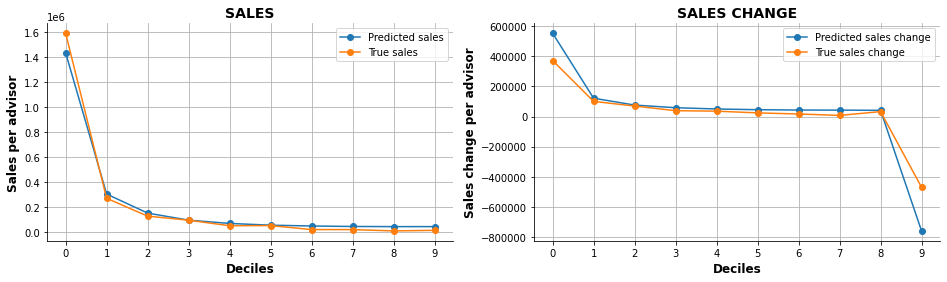

In [121]:
fig = plt.figure()
fig.set_size_inches(16, 4)
res_plot_s1, deciles_s1 = plot_sales_deciles(stack_model, X_test, y_test, index=X_test.index, 
                                     ax=fig.add_subplot(1,2,1), cumulative=False, log_transform=False, title='SALES', exp=False)
res_plot_sch1, deciles_sch1 = plot_sale_change_deciles(stack_model, X_test, y_test, data.loc[X_test.index, 'sales_12M'], index=X_test.index, 
                                     ax=fig.add_subplot(1,2,2), cumulative=False, title='SALES CHANGE', exp=False)
plt.savefig('temp.jpg')

In [122]:
res_plot_s1.to_csv('Res_reg_x_noof_x_aum_others_03.csv')

#### Features importance

In [60]:
feature_importance_drop = dropcol_importances(stack_model, X_train, y_train, X_valid=X_test, y_valid=y_test, metric=dropcol_imp_r2_metric)
# feature_importance_premute = importances(etr_imp, X_valid=X_test, y_valid=y_test, metric=dropcol_imp_r2_metric)

In [78]:
# feature_importance_drop = dropcol_importances(stack_model, X_train, y_train, X_valid=X_test, y_valid=y_test, metric=dropcol_imp_r2_metric)
feature_importance_premute = importances(stack_model, X_valid=X_test, y_valid=y_test, metric=dropcol_imp_r2_metric)

In [125]:
# feature_importance = feature_importance_drop.merge(feature_importance_premute, left_index=True, right_index=True)
feature_importance = feature_importance_premute.copy()
feature_importance.columns = ['importance']
# feature_importance['sum'] = feature_importance['drop'] + feature_importance['premute']
feature_importance = feature_importance.sort_values(by='importance',ascending=False)
feature_importance

,importance
Feature,
sales_curr,1.507808e-01
no_of_sales_12M_10K,6.952321e-02
no_of_Redemption_12M_10K,3.518988e-02
pos_net_sales_12M,3.125169e-02
pos_aum_AC_FIXED_INCOME_MUNI,3.082718e-02
no_of_Redemption_12M_1,2.671704e-02
redemption_curr,2.156401e-02
pos_aum_AC_FIXED_INCOME_TAXABLE,1.934415e-02
no_of_sales_12M_1,8.772993e-03


In [126]:
feature_importance.to_csv('imp_features_reg.csv')

In [101]:
feature_importance = pd.read_csv('imp_features_reg.csv', index_col=0)

In [102]:
cols_imp_sorted = list(feature_importance['importance'].index)

In [103]:
important_cols = list(feature_importance.loc[feature_importance['importance'] > 0].index)

In [104]:
important_cols

['sales_curr',
 'no_of_sales_12M_10K',
 'no_of_Redemption_12M_10K',
 'pos_net_sales_12M',
 'pos_aum_AC_FIXED_INCOME_MUNI',
 'no_of_Redemption_12M_1',
 'redemption_curr',
 'pos_aum_AC_FIXED_INCOME_TAXABLE',
 'no_of_sales_12M_1',
 'pos_aum_AC_TARGET',
 'neg_net_sales_curr',
 'pos_aum_AC_PHYSICAL_COMMODITY',
 'pos_net_no_of_sales_12M_1',
 'pos_net_no_of_assetclass_sales_12M_10K',
 'neg_net_no_of_sales_12M_1',
 'neg_net_no_of_assetclass_sales_12M_10K',
 'pos_net_no_of_fund_sales_12M_10K',
 'neg_aum_P_SMA',
 'pos_aum_AC_MULTIPLE',
 'neg_aum_P_MF',
 'neg_aum_AC_FIXED_INCOME_MUNI',
 'neg_aum_AC_MULTIPLE',
 'pos_net_no_of_funds_sold_12M_1',
 'pos_aum_P_ETF',
 'pos_aum_AC_REAL_ESTATE']

In [105]:
X_presel_impcoll = X_presel_mcoll[important_cols]

In [106]:
X_presel_outl = X_presel_impcoll.loc[dbs_noise]
y_presel_outl = data.loc[dbs_noise, target]

### Split data into train and test sets

In [107]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_presel_outl, y_presel_outl, test_size=0.5, random_state=30)

In [156]:
gbr1 = GradientBoostingRegressor(loss='huber', 
                                criterion='friedman_mse',
                                learning_rate=0.1,
                                n_estimators=100,
                                random_state=random_state)
etr1 = ExtraTreesRegressor(random_state=random_state)
dtr1 = DecisionTreeRegressor()

base_estimators1 = [('gbr',gbr1), ('dtr',dtr1), ('etr',etr1)]
final_estimator1 = LinearRegression()
stack_model1 = StackingRegressor(estimators=base_estimators1, final_estimator=final_estimator1, cv=10, verbose=1, n_jobs=-1)

In [157]:
stack_model1 = stack_model1.fit(X_train1, y_train1)
print('CV Results \n================================')
display(cv_rep(stack_model1, X_train1, y_train1, cv, scoring))
test_score(stack_model1, X_test1, y_test1)

CV Results 


,mae,explained_variance,r2
mean_train,109513.614908,0.811716,0.811585
std_train,15783.495423,0.052522,0.052502
mean_test,218974.136626,0.314009,0.312927
std_test,22434.782710,0.120451,0.120295



Validation on the test set 
mean_absolute_error:  212601.70701347786
explained_variance_score:  0.44591683692611594
r2_score:  0.4459123432422083


In [158]:
len(X_test)

4684

In [159]:
pickle.dump(stack_model1, open('stack_model_reg_imp.mdl', 'wb'))

In [151]:
stack_model1 = pickle.load(open('stack_model_reg_imp.mdl', 'rb'))

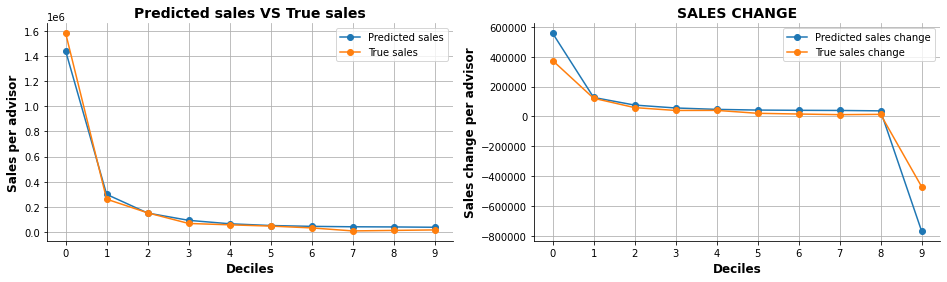

In [152]:
fig = plt.figure()
fig.set_size_inches(16, 4)
res_plot_s1, deciles_s1 = plot_sales_deciles(stack_model1, X_test1, y_test1, index=X_test1.index, 
                                     ax=fig.add_subplot(1,2,1), cumulative=False, log_transform=False, title='Predicted sales VS True sales', exp=False)
res_plot_sch1, deciles_sch1 = plot_sale_change_deciles(stack_model1, X_test1, y_test1, data.loc[X_test1.index, 'sales_12M'], index=X_test1.index, 
                                     ax=fig.add_subplot(1,2,2), cumulative=False, title='SALES CHANGE', exp=False)
plt.savefig('temp.jpg')

In [162]:
res_plot_s1.to_csv('Res1_reg_x_noof_x_aum_others_03.csv')

#### Compare models before and after feature importance study

In [7]:
x_noof_x_aum_others = pd.read_csv('Res_reg_x_noof_x_aum_others_03.csv', index_col=0)
x_noof_x_aum_others['delta'] = np.abs(x_noof_x_aum_others['sales_pred'] - x_noof_x_aum_others['sales_true'])

x_noof_x_aum_others_1 = pd.read_csv('Res1_reg_x_noof_x_aum_others_03.csv', index_col=0)
x_noof_x_aum_others_1['delta'] = np.abs(x_noof_x_aum_others_1['sales_pred'] - x_noof_x_aum_others_1['sales_true'])

In [8]:
res_data = x_noof_x_aum_others.copy()
res_data = res_data.drop(columns=['sales_pred', 'sales_true'])
res_data.columns = ['all_features']

In [9]:
res_data['important_features'] = x_noof_x_aum_others_1['delta']

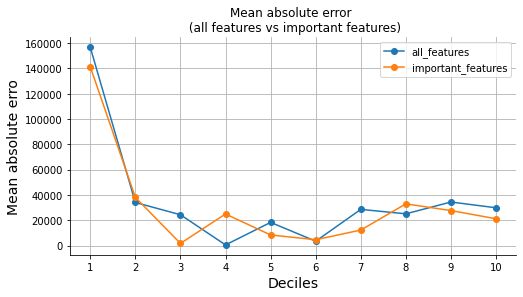

In [13]:
fig = plt.figure()
fig.set_size_inches(8, 4)
ax=fig.add_subplot(1,1,1)
x = np.arange(1,11,1)
colors = ['tab:blue', 'tab:orange']
for i, color in zip(list(res_data.columns), colors):
    y = res_data[i]
    ax.plot(x, y, marker='o', color=color)
    
ax.legend(list(res_data.columns))
spines = {'left': True,
          'right': False,
          'top': False,
          'bottom': True}
for i in list(spines.keys()):
    ax.spines[i].set_visible(spines[i])
# ax.set_yscale('log')
ax.set_xticks(np.arange(1,11,1))
ax.set_xlabel('Deciles', fontsize=14)
ax.set_ylabel('Mean absolute erro', fontsize=14)
ax.set_title('Mean absolute error \n (all features vs important features)')
ax.grid(True)
plt.savefig('temp.jpg')

### Results analysis

In [176]:
# total_mean1, lift1 = get_lift_chart(stack_model1, data[X_test1.columns], data[target], by_class=1, exp=False)
# print('Total population: ', len(X_test1))
# print('Total mean: ', total_mean1, '\n')
# lift1
y1, total_mean1, lift1 = get_lift_chart(stack_model1, data_raw.loc[X_test1.index], X_test1, by_class=1, exp=False)
print('Total population: ', len(X_test1))
print('Total mean: ', total_mean1, '\n')
lift1

Total population:  4684
Total mean:  226193.81607464427 



,n_samples,dec_mean,dec_lift_ovr_mean,n_cum_samples,cum_mean,cum_lift_ovr_mean
0,468.0,1.440016e+06,5.366293,468.0,1.440016e+06,5.366293
1,468.0,2.992358e+05,0.322918,936.0,1.739252e+06,5.689211
2,468.0,1.507306e+05,-0.333622,1404.0,1.889983e+06,5.355589
3,468.0,9.284049e+04,-0.589553,1872.0,1.982823e+06,4.766036
4,468.0,6.534356e+04,-0.711117,2340.0,2.048167e+06,4.054919
5,468.0,5.141765e+04,-0.772683,2808.0,2.099584e+06,3.282235
6,468.0,4.477825e+04,-0.802036,3276.0,2.144363e+06,2.480200
7,468.0,4.146840e+04,-0.816669,3744.0,2.185831e+06,1.663531
8,468.0,4.013760e+04,-0.822552,4212.0,2.225969e+06,0.840979
9,472.0,3.758172e+04,-0.833852,4684.0,2.263550e+06,0.007127


In [172]:
lift1.to_csv('Sales_reg_lift_temp.csv')

In [227]:
y1.to_csv('Sales_reg_test_data_deciles.csv')

In [169]:
important_cols

['sales_curr',
 'no_of_sales_12M_10K',
 'no_of_Redemption_12M_10K',
 'pos_net_sales_12M',
 'pos_aum_AC_FIXED_INCOME_MUNI',
 'no_of_Redemption_12M_1',
 'redemption_curr',
 'pos_aum_AC_FIXED_INCOME_TAXABLE',
 'no_of_sales_12M_1',
 'pos_aum_AC_TARGET',
 'neg_net_sales_curr',
 'pos_aum_AC_PHYSICAL_COMMODITY',
 'pos_net_no_of_sales_12M_1',
 'pos_net_no_of_assetclass_sales_12M_10K',
 'neg_net_no_of_sales_12M_1',
 'neg_net_no_of_assetclass_sales_12M_10K',
 'pos_net_no_of_fund_sales_12M_10K',
 'neg_aum_P_SMA',
 'pos_aum_AC_MULTIPLE',
 'neg_aum_P_MF',
 'neg_aum_AC_FIXED_INCOME_MUNI',
 'neg_aum_AC_MULTIPLE',
 'pos_net_no_of_funds_sold_12M_1',
 'pos_aum_P_ETF',
 'pos_aum_AC_REAL_ESTATE']

In [177]:
y1.columns

Index(['no_of_sales_12M_1', 'no_of_Redemption_12M_1', 'no_of_sales_12M_10K',
       'no_of_Redemption_12M_10K', 'no_of_funds_sold_12M_1',
       'no_of_funds_redeemed_12M_1', 'no_of_fund_sales_12M_10K',
       'no_of_funds_Redemption_12M_10K', 'no_of_assetclass_sold_12M_1',
       'no_of_assetclass_redeemed_12M_1', 'no_of_assetclass_sales_12M_10K',
       'no_of_assetclass_Redemption_12M_10K', 'No_of_fund_curr',
       'No_of_asset_curr', 'AUM', 'sales_curr', 'sales_12M', 'redemption_curr',
       'redemption_12M', 'new_Fund_added_12M', 'aum_AC_EQUITY',
       'aum_AC_FIXED_INCOME_MUNI', 'aum_AC_FIXED_INCOME_TAXABLE',
       'aum_AC_MONEY', 'aum_AC_MULTIPLE', 'aum_AC_PHYSICAL_COMMODITY',
       'aum_AC_REAL_ESTATE', 'aum_AC_TARGET', 'aum_P_529', 'aum_P_ALT',
       'aum_P_CEF', 'aum_P_ETF', 'aum_P_MF', 'aum_P_SMA', 'aum_P_UCITS',
       'aum_P_UIT', 'sales_12M_target', 'new_Fund_added_12M_target',
       'delta_sales_12M_18_19', 'net_no_of_sales_12M_1',
       'net_no_of_sales_12M_10K'

In [110]:
data1 = data_raw.copy()
data1['sales_12M_preds'] = stack_model1.predict(data[X_test1.columns])
data1['delta_sales_12M_18_preds'] = (data1['sales_12M_preds'] - data1['sales_12M'])

In [178]:
data2 = y1.copy()

In [179]:
# data2 = data_raw.copy()
data2['aum_ac_sum'] = data2['aum_AC_FIXED_INCOME_TAXABLE'] + data2['aum_AC_FIXED_INCOME_MUNI'] + data2['aum_AC_TARGET'] + data2['aum_AC_REAL_ESTATE'] + data2['aum_AC_MULTIPLE'] + data2['aum_AC_PHYSICAL_COMMODITY']
data2['pos_ac_aum_sum'] = data2['pos_aum_AC_FIXED_INCOME_TAXABLE'] + data2['pos_aum_AC_EQUITY'] + data2['pos_aum_AC_TARGET'] + data2['pos_aum_AC_REAL_ESTATE'] + data2['pos_aum_AC_MULTIPLE'] + data2['pos_aum_AC_PHYSICAL_COMMODITY']
data2['neg_ac_aum_sum'] = data2['neg_aum_AC_FIXED_INCOME_TAXABLE'] + data2['neg_aum_AC_EQUITY'] + data2['neg_aum_AC_TARGET'] + data2['neg_aum_AC_REAL_ESTATE'] + data2['neg_aum_AC_MULTIPLE'] + data2['neg_aum_AC_PHYSICAL_COMMODITY']

In [180]:
# data2 = data_raw.copy()
data2['aum_p_sum'] = data2['aum_P_SMA'] + data2['aum_P_CEF'] + data2['aum_P_ETF'] + data2['aum_P_MF']
data2['pos_p_aum_sum'] = data2['pos_aum_P_SMA'] + data2['pos_aum_P_CEF'] + data2['pos_aum_P_ETF'] + data2['pos_aum_P_MF']
data2['neg_p_aum_sum'] = data2['neg_aum_P_SMA'] + data2['neg_aum_P_CEF'] + data2['neg_aum_P_ETF'] + data2['neg_aum_P_MF']

In [181]:
data2['aum_sum'] = data2['aum_ac_sum'] + data2['aum_p_sum']
data2['pos_aum_sum'] = data2['pos_ac_aum_sum'] + data2['pos_p_aum_sum']
data2['neg_aum_sum'] = data2['neg_ac_aum_sum'] + data2['neg_p_aum_sum']

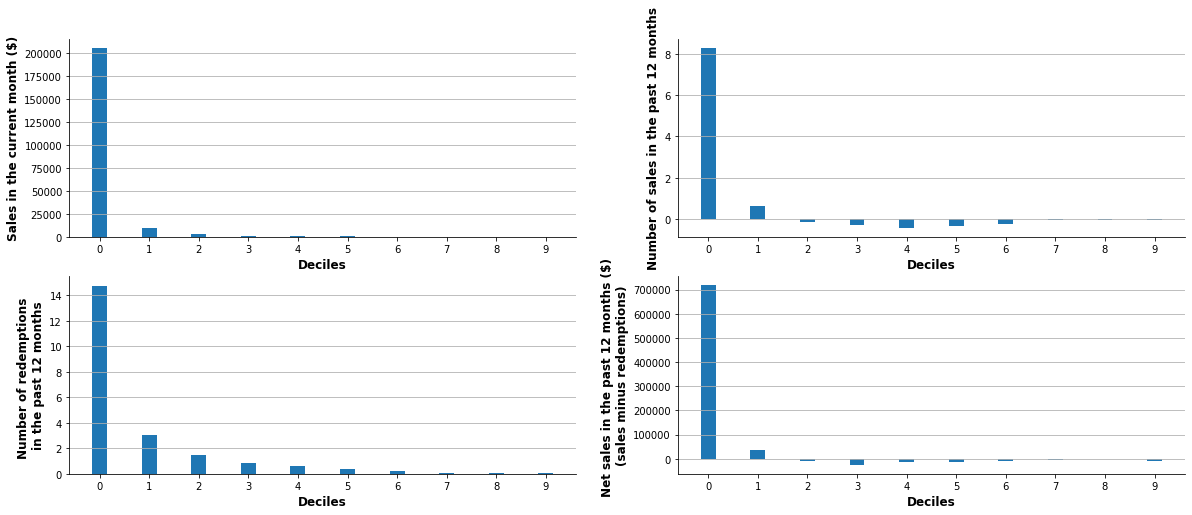

In [216]:
fig = plt.figure()
fig.set_size_inches(20, 8)

ax=fig.add_subplot(2,2,1)
plot_diagram_deciles(data2, y='sales_curr', ax=ax, y_title='Sales in the current month ($)', title='')

ax=fig.add_subplot(2,2,2)
plot_diagram_deciles(data2, y='no_of_sales_12M_10K', ax=ax, y_title='Number of sales in the past 12 months', title='')

ax=fig.add_subplot(2,2,3)
plot_diagram_deciles(data2, y='no_of_Redemption_12M_10K', ax=ax, y_title='Number of redemptions \nin the past 12 months', title='')

ax=fig.add_subplot(2,2,4)
plot_diagram_deciles(data2, y='pos_net_sales_12M', ax=ax, y_title='Net sales in the past 12 months ($) \n(sales minus redemptions)', title='')

# ax=fig.add_subplot(3,2,5)
# plot_diagram_xy(data2, x='pos_aum_AC_FIXED_INCOME_MUNI', y='sales_12M_target', ax=ax, x_title='Deciles: pos_aum_AC_FIXED_INCOME_MUNI per advisor', 
#                 y_title='Sales ($) target', title='', tick_labelsIprefix='$')

# ax=fig.add_subplot(3,2,6)
# plot_diagram_xy(data2, x='no_of_Redemption_12M_1', y='sales_12M_target', ax=ax, x_title='Deciles: no_of_Redemption_12M_1 per advisor', 
#                 y_title='Sales ($) target', title='', tick_labelsIprefix='$')

plt.savefig('temp.jpg')

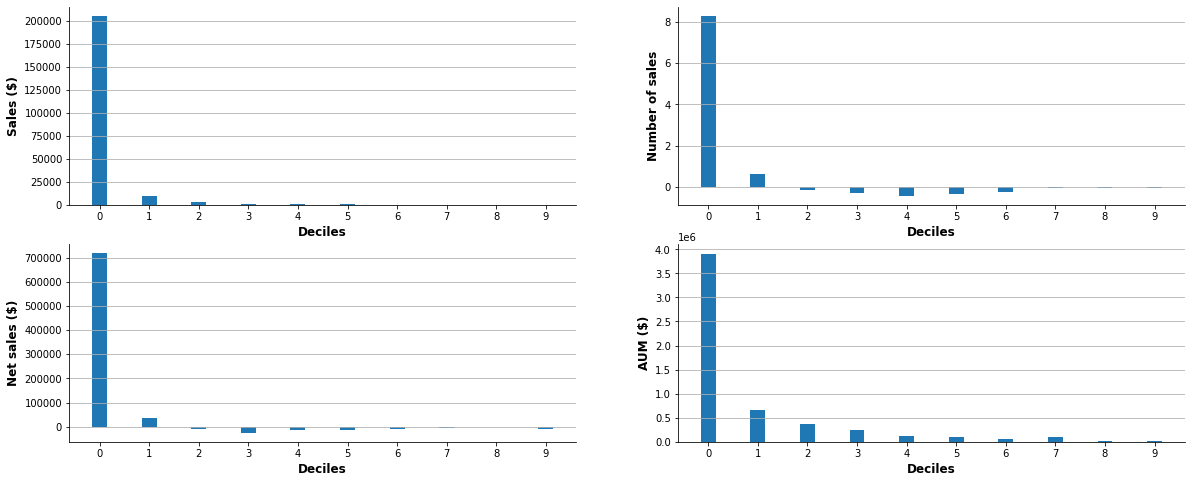

In [226]:
fig = plt.figure()
fig.set_size_inches(20, 8)

ax=fig.add_subplot(2,2,1)
plot_diagram_deciles(data2, y='sales_curr', ax=ax, y_title='Sales ($)', title='')

ax=fig.add_subplot(2,2,2)
plot_diagram_deciles(data2, y='net_no_of_sales_12M_10K', ax=ax, y_title='Number of sales', title='')

# ax=fig.add_subplot(2,2,3)
# plot_diagram_deciles(data2, y='no_of_Redemption_12M_10K', ax=ax, y_title='Number of redemptions', title='')

ax=fig.add_subplot(2,2,3)
plot_diagram_deciles(data2, y='net_sales_12M', ax=ax, y_title='Net sales ($)', title='')

ax=fig.add_subplot(2,2,4)
plot_diagram_deciles(data2, y='pos_AUM', ax=ax, y_title='AUM ($)', title='')

# ax=fig.add_subplot(3,2,6)
# plot_diagram_xy(data2, x='no_of_Redemption_12M_1', y='sales_12M_target', ax=ax, x_title='Deciles: no_of_Redemption_12M_1 per advisor', 
#                 y_title='Sales ($) target', title='', tick_labelsIprefix='$')

plt.savefig('temp.jpg')

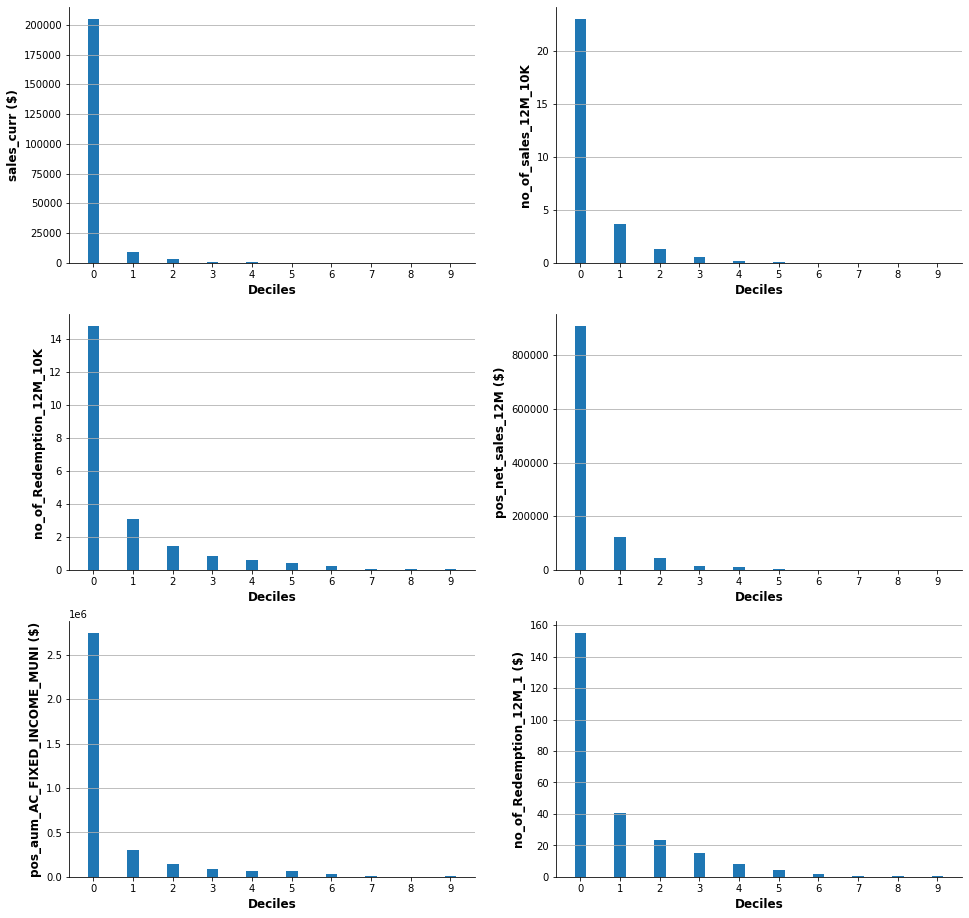

In [196]:
fig = plt.figure()
fig.set_size_inches(16, 16)

ax=fig.add_subplot(3,2,1)
plot_diagram_deciles(data2, y='sales_curr', ax=ax, y_title='sales_curr ($)', title='')

ax=fig.add_subplot(3,2,2)
plot_diagram_deciles(data2, y='no_of_sales_12M_10K', ax=ax, y_title='no_of_sales_12M_10K', title='')

ax=fig.add_subplot(3,2,3)
plot_diagram_deciles(data2, y='no_of_Redemption_12M_10K', ax=ax, y_title='no_of_Redemption_12M_10K', title='')

ax=fig.add_subplot(3,2,4)
plot_diagram_deciles(data2, y='pos_net_sales_12M', ax=ax, y_title='pos_net_sales_12M ($)', title='')

ax=fig.add_subplot(3,2,5)
plot_diagram_deciles(data2, y='pos_aum_AC_FIXED_INCOME_MUNI', ax=ax, y_title='pos_aum_AC_FIXED_INCOME_MUNI ($)', title='')

ax=fig.add_subplot(3,2,6)
plot_diagram_deciles(data2, y='no_of_Redemption_12M_1', ax=ax, y_title='no_of_Redemption_12M_1 ($)', title='')

plt.savefig('temp.jpg')

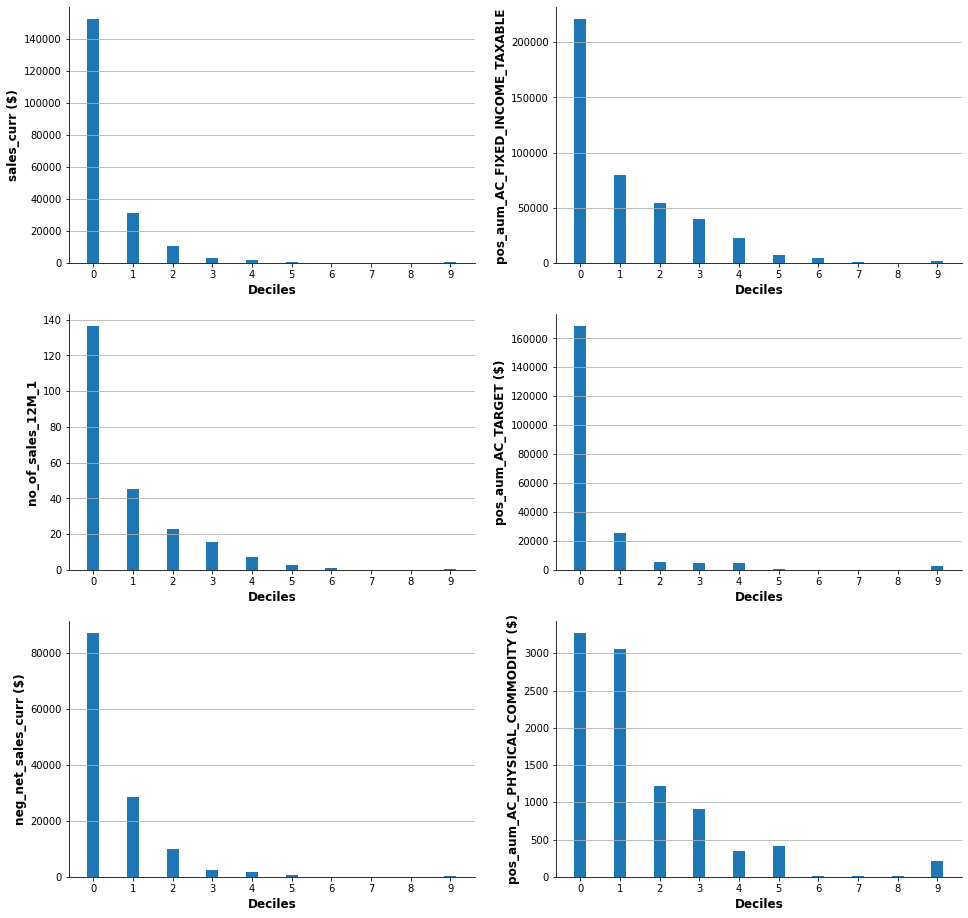

In [199]:
fig = plt.figure()
fig.set_size_inches(16, 16)

ax=fig.add_subplot(3,2,1)
plot_diagram_deciles(data2, y='redemption_curr', ax=ax, y_title='sales_curr ($)', title='')

ax=fig.add_subplot(3,2,2)
plot_diagram_deciles(data2, y='pos_aum_AC_FIXED_INCOME_TAXABLE', ax=ax, y_title='pos_aum_AC_FIXED_INCOME_TAXABLE', title='')

ax=fig.add_subplot(3,2,3)
plot_diagram_deciles(data2, y='no_of_sales_12M_1', ax=ax, y_title='no_of_sales_12M_1', title='')

ax=fig.add_subplot(3,2,4)
plot_diagram_deciles(data2, y='pos_aum_AC_TARGET', ax=ax, y_title='pos_aum_AC_TARGET ($)', title='')

ax=fig.add_subplot(3,2,5)
plot_diagram_deciles(data2, y='neg_net_sales_curr', ax=ax, y_title='neg_net_sales_curr ($)', title='')

ax=fig.add_subplot(3,2,6)
plot_diagram_deciles(data2, y='pos_aum_AC_PHYSICAL_COMMODITY', ax=ax, y_title='pos_aum_AC_PHYSICAL_COMMODITY ($)', title='')

plt.savefig('temp.jpg')

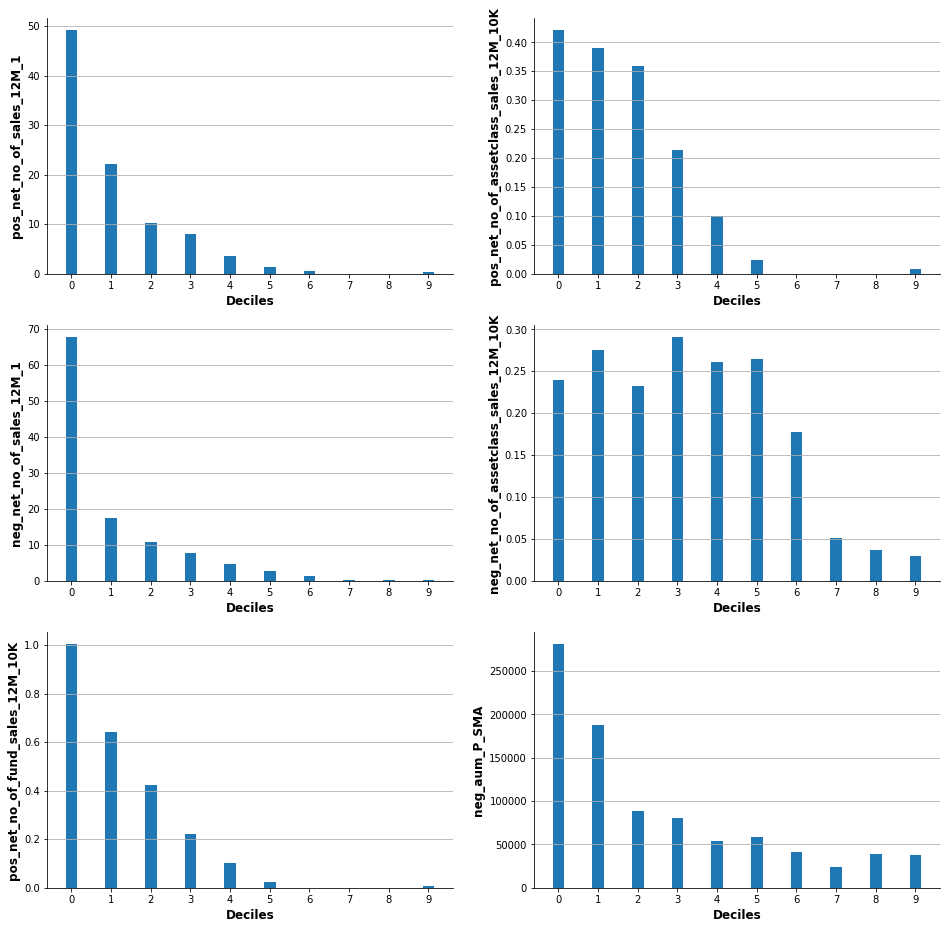

In [200]:
fig = plt.figure()
fig.set_size_inches(16, 16)

ax=fig.add_subplot(3,2,1)
plot_diagram_deciles(data2, y='pos_net_no_of_sales_12M_1', ax=ax, y_title='pos_net_no_of_sales_12M_1', title='')

ax=fig.add_subplot(3,2,2)
plot_diagram_deciles(data2, y='pos_net_no_of_assetclass_sales_12M_10K', ax=ax, y_title='pos_net_no_of_assetclass_sales_12M_10K', title='')

ax=fig.add_subplot(3,2,3)
plot_diagram_deciles(data2, y='neg_net_no_of_sales_12M_1', ax=ax, y_title='neg_net_no_of_sales_12M_1', title='')

ax=fig.add_subplot(3,2,4)
plot_diagram_deciles(data2, y='neg_net_no_of_assetclass_sales_12M_10K', ax=ax, y_title='neg_net_no_of_assetclass_sales_12M_10K', title='')

ax=fig.add_subplot(3,2,5)
plot_diagram_deciles(data2, y='pos_net_no_of_fund_sales_12M_10K', ax=ax, y_title='pos_net_no_of_fund_sales_12M_10K', title='')

ax=fig.add_subplot(3,2,6)
plot_diagram_deciles(data2, y='neg_aum_P_SMA', ax=ax, y_title='neg_aum_P_SMA', title='')

plt.savefig('temp.jpg')

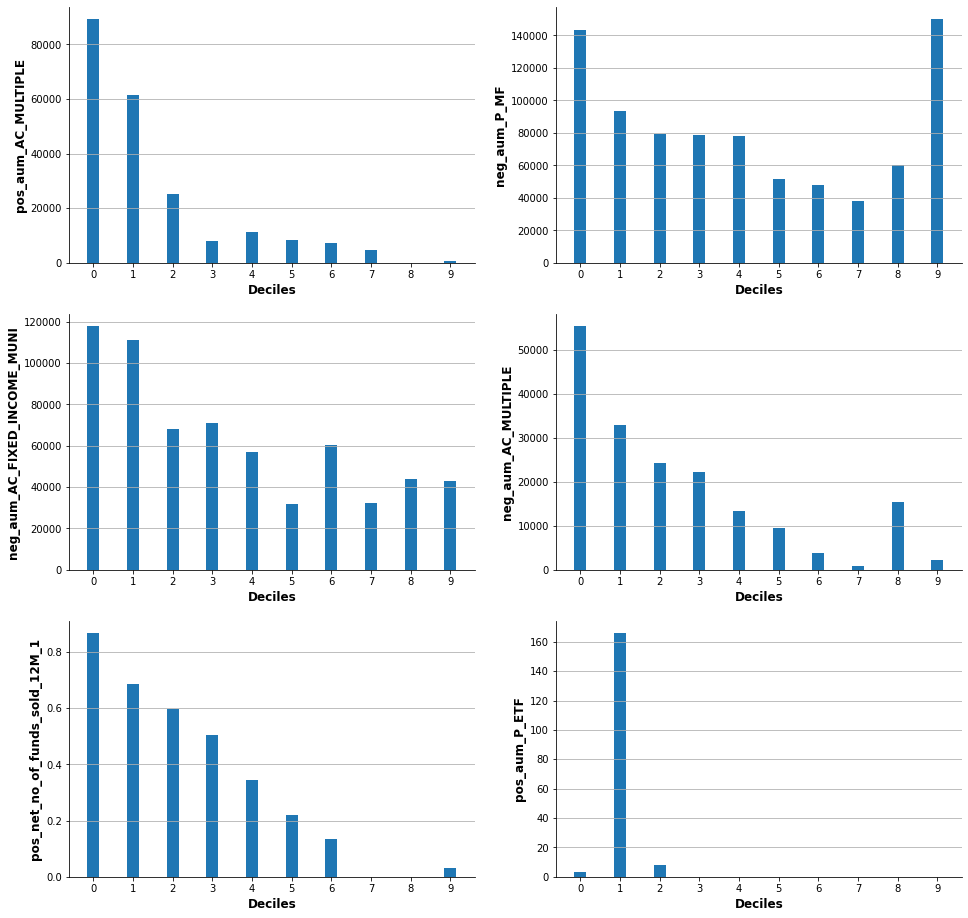

In [201]:
fig = plt.figure()
fig.set_size_inches(16, 16)

ax=fig.add_subplot(3,2,1)
plot_diagram_deciles(data2, y='pos_aum_AC_MULTIPLE', ax=ax, y_title='pos_aum_AC_MULTIPLE', title='')

ax=fig.add_subplot(3,2,2)
plot_diagram_deciles(data2, y='neg_aum_P_MF', ax=ax, y_title='neg_aum_P_MF', title='')

ax=fig.add_subplot(3,2,3)
plot_diagram_deciles(data2, y='neg_aum_AC_FIXED_INCOME_MUNI', ax=ax, y_title='neg_aum_AC_FIXED_INCOME_MUNI', title='')

ax=fig.add_subplot(3,2,4)
plot_diagram_deciles(data2, y='neg_aum_AC_MULTIPLE', ax=ax, y_title='neg_aum_AC_MULTIPLE', title='')

ax=fig.add_subplot(3,2,5)
plot_diagram_deciles(data2, y='pos_net_no_of_funds_sold_12M_1', ax=ax, y_title='pos_net_no_of_funds_sold_12M_1', title='')

ax=fig.add_subplot(3,2,6)
plot_diagram_deciles(data2, y='pos_aum_P_ETF', ax=ax, y_title='pos_aum_P_ETF', title='')

plt.savefig('temp.jpg')

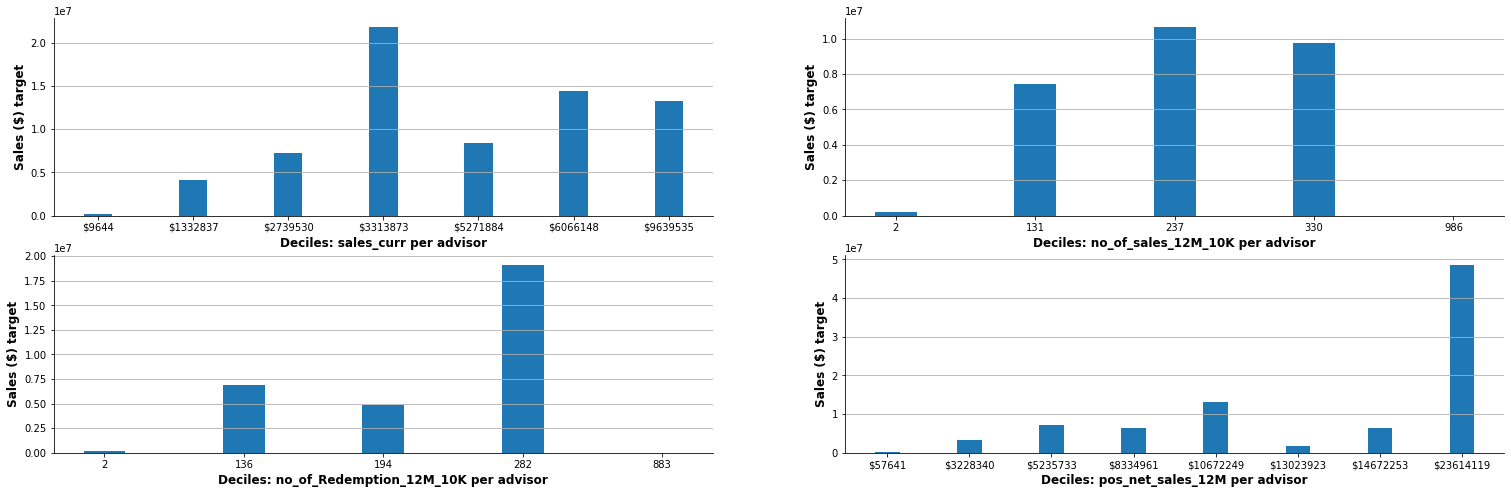

In [182]:
fig = plt.figure()
fig.set_size_inches(26, 8)

ax=fig.add_subplot(2,2,1)
plot_diagram_xy(data2, x='sales_curr', y='sales_12M_target', ax=ax, x_title='Deciles: sales_curr per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='$')

ax=fig.add_subplot(2,2,2)
plot_diagram_xy(data2, x='no_of_sales_12M_10K', y='sales_12M_target', ax=ax, x_title='Deciles: no_of_sales_12M_10K per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='')

ax=fig.add_subplot(2,2,3)
plot_diagram_xy(data2, x='no_of_Redemption_12M_10K', y='sales_12M_target', ax=ax, x_title='Deciles: no_of_Redemption_12M_10K per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='')

ax=fig.add_subplot(2,2,4)
plot_diagram_xy(data2, x='pos_net_sales_12M', y='sales_12M_target', ax=ax, x_title='Deciles: pos_net_sales_12M per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='$')

# ax=fig.add_subplot(3,2,5)
# plot_diagram_xy(data2, x='pos_aum_AC_FIXED_INCOME_MUNI', y='sales_12M_target', ax=ax, x_title='Deciles: pos_aum_AC_FIXED_INCOME_MUNI per advisor', 
#                 y_title='Sales ($) target', title='', tick_labelsIprefix='$')

# ax=fig.add_subplot(3,2,6)
# plot_diagram_xy(data2, x='no_of_Redemption_12M_1', y='sales_12M_target', ax=ax, x_title='Deciles: no_of_Redemption_12M_1 per advisor', 
#                 y_title='Sales ($) target', title='', tick_labelsIprefix='$')

plt.savefig('temp.jpg')

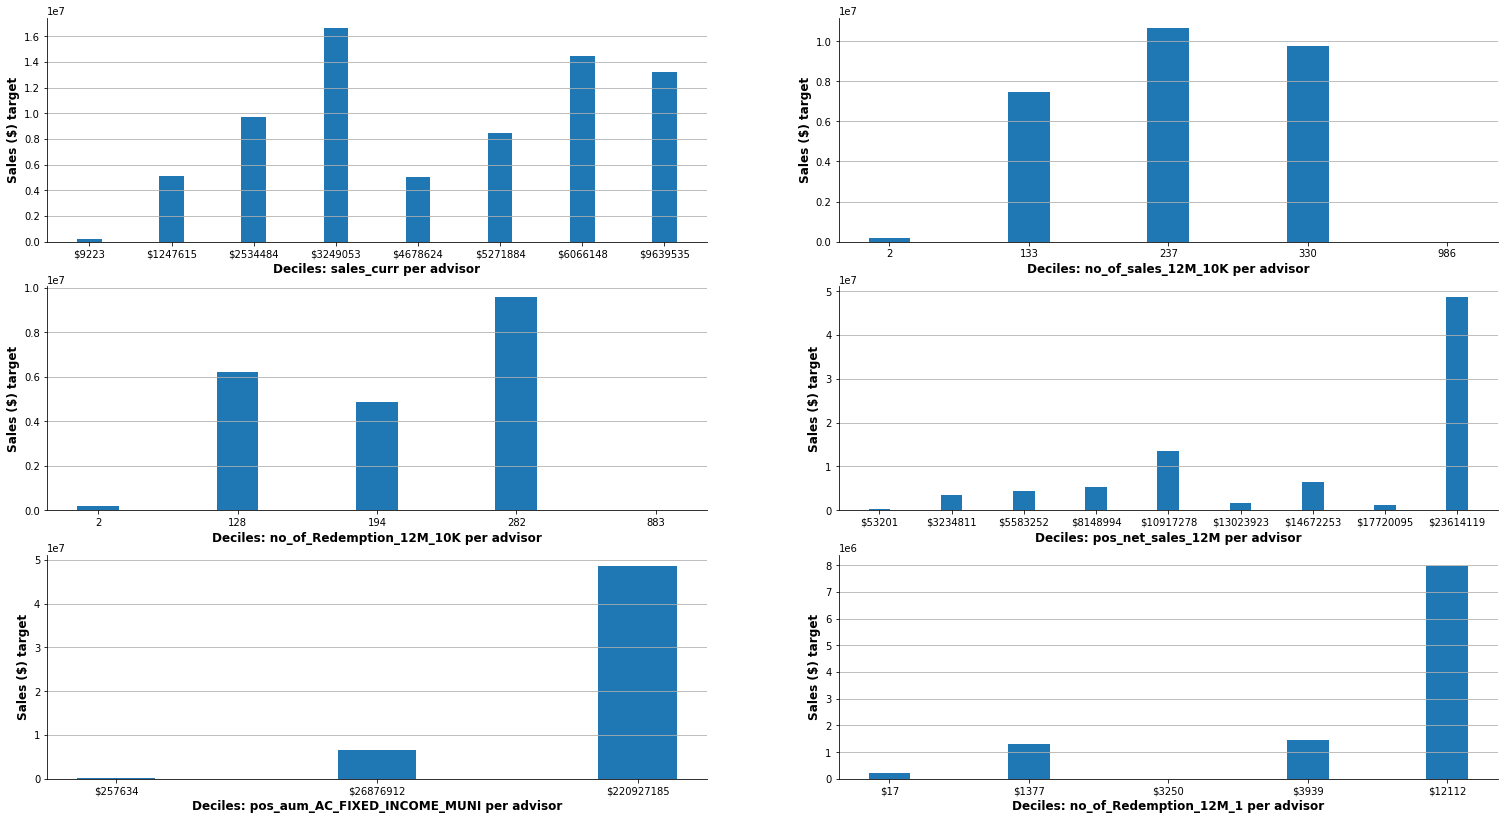

In [135]:
fig = plt.figure()
fig.set_size_inches(26, 14)

ax=fig.add_subplot(3,2,1)
plot_diagram_xy(data2, x='sales_curr', y='sales_12M_target', ax=ax, x_title='Deciles: sales_curr per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='$')

ax=fig.add_subplot(3,2,2)
plot_diagram_xy(data2, x='no_of_sales_12M_10K', y='sales_12M_target', ax=ax, x_title='Deciles: no_of_sales_12M_10K per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='')

ax=fig.add_subplot(3,2,3)
plot_diagram_xy(data2, x='no_of_Redemption_12M_10K', y='sales_12M_target', ax=ax, x_title='Deciles: no_of_Redemption_12M_10K per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='')

ax=fig.add_subplot(3,2,4)
plot_diagram_xy(data2, x='pos_net_sales_12M', y='sales_12M_target', ax=ax, x_title='Deciles: pos_net_sales_12M per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='$')

ax=fig.add_subplot(3,2,5)
plot_diagram_xy(data2, x='pos_aum_AC_FIXED_INCOME_MUNI', y='sales_12M_target', ax=ax, x_title='Deciles: pos_aum_AC_FIXED_INCOME_MUNI per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='$')

ax=fig.add_subplot(3,2,6)
plot_diagram_xy(data2, x='no_of_Redemption_12M_1', y='sales_12M_target', ax=ax, x_title='Deciles: no_of_Redemption_12M_1 per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='$')

plt.savefig('temp.jpg')

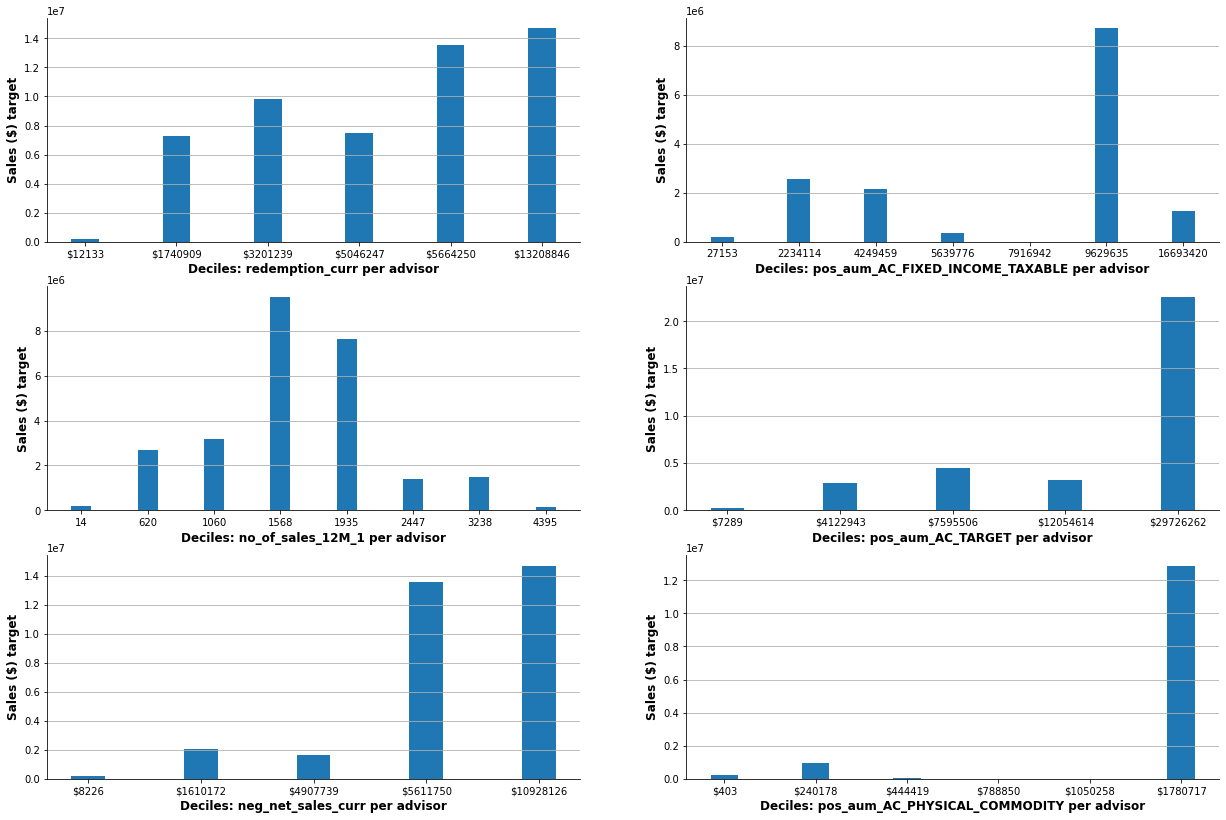

In [137]:
fig = plt.figure()
fig.set_size_inches(21, 14)

ax=fig.add_subplot(3,2,1)
plot_diagram_xy(data2, x='redemption_curr', y='sales_12M_target', ax=ax, x_title='Deciles: redemption_curr per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='$')

ax=fig.add_subplot(3,2,2)
plot_diagram_xy(data2, x='pos_aum_AC_FIXED_INCOME_TAXABLE', y='sales_12M_target', ax=ax, x_title='Deciles: pos_aum_AC_FIXED_INCOME_TAXABLE per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='')

ax=fig.add_subplot(3,2,3)
plot_diagram_xy(data2, x='no_of_sales_12M_1', y='sales_12M_target', ax=ax, x_title='Deciles: no_of_sales_12M_1 per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='')

ax=fig.add_subplot(3,2,4)
plot_diagram_xy(data2, x='pos_aum_AC_TARGET', y='sales_12M_target', ax=ax, x_title='Deciles: pos_aum_AC_TARGET per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='$')

ax=fig.add_subplot(3,2,5)
plot_diagram_xy(data2, x='neg_net_sales_curr', y='sales_12M_target', ax=ax, x_title='Deciles: neg_net_sales_curr per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='$')

ax=fig.add_subplot(3,2,6)
plot_diagram_xy(data2, x='pos_aum_AC_PHYSICAL_COMMODITY', y='sales_12M_target', ax=ax, x_title='Deciles: pos_aum_AC_PHYSICAL_COMMODITY per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='$')

plt.savefig('temp.jpg')

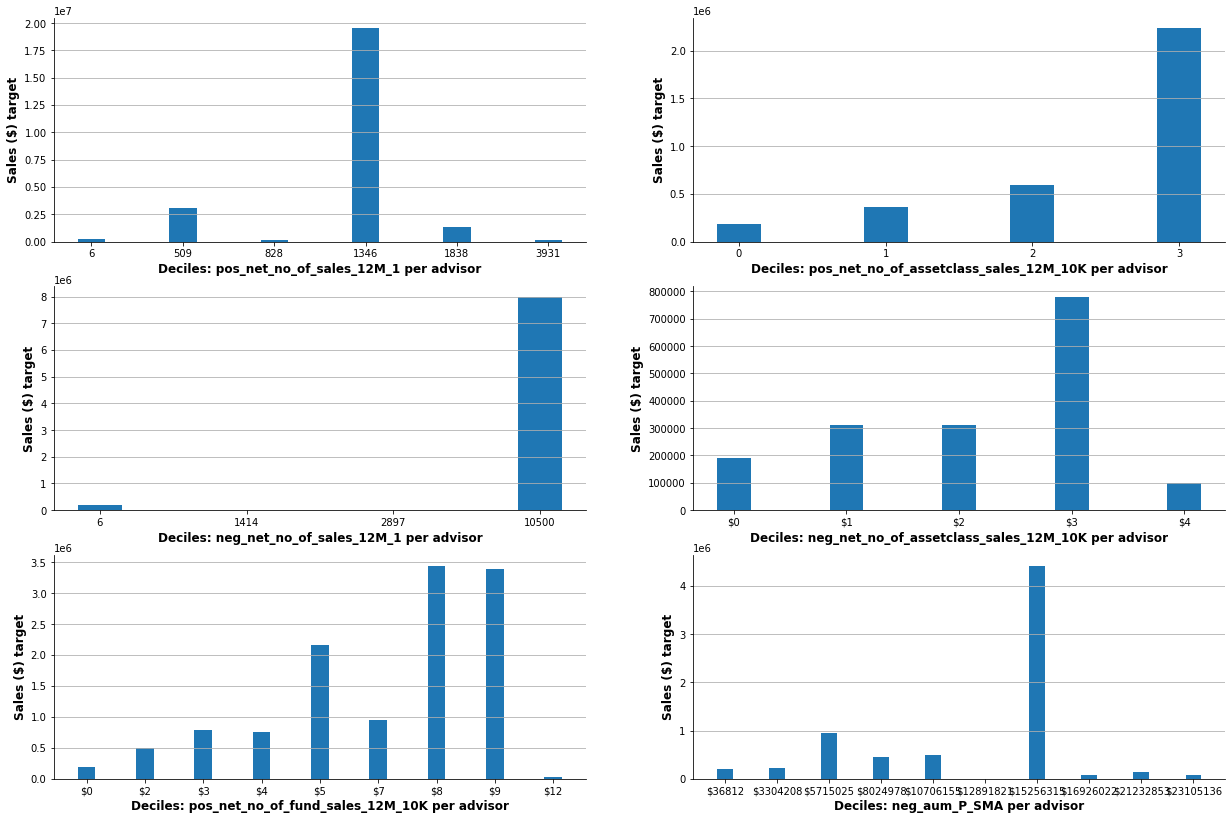

In [138]:
fig = plt.figure()
fig.set_size_inches(21, 14)

ax=fig.add_subplot(3,2,1)
plot_diagram_xy(data2, x='pos_net_no_of_sales_12M_1', y='sales_12M_target', ax=ax, x_title='Deciles: pos_net_no_of_sales_12M_1 per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='')

ax=fig.add_subplot(3,2,2)
plot_diagram_xy(data2, x='pos_net_no_of_assetclass_sales_12M_10K', y='sales_12M_target', ax=ax, x_title='Deciles: pos_net_no_of_assetclass_sales_12M_10K per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='')

ax=fig.add_subplot(3,2,3)
plot_diagram_xy(data2, x='neg_net_no_of_sales_12M_1', y='sales_12M_target', ax=ax, x_title='Deciles: neg_net_no_of_sales_12M_1 per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='')

ax=fig.add_subplot(3,2,4)
plot_diagram_xy(data2, x='neg_net_no_of_assetclass_sales_12M_10K', y='sales_12M_target', ax=ax, x_title='Deciles: neg_net_no_of_assetclass_sales_12M_10K per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='$')

ax=fig.add_subplot(3,2,5)
plot_diagram_xy(data2, x='pos_net_no_of_fund_sales_12M_10K', y='sales_12M_target', ax=ax, x_title='Deciles: pos_net_no_of_fund_sales_12M_10K per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='$')

ax=fig.add_subplot(3,2,6)
plot_diagram_xy(data2, x='neg_aum_P_SMA', y='sales_12M_target', ax=ax, x_title='Deciles: neg_aum_P_SMA per advisor', 
                y_title='Sales ($) target', title='', tick_labelsIprefix='$')

plt.savefig('temp.jpg')

#### Conclusions

1. Advisors that have higher sales in current month will likely have higher sales next year.
2. Advisors that have higher net sales in current month will likely increase sales next year and vice-versa.
3. Advisors that have positive net number of sales that are more than $1 in the last 12 months will likely increase their sales next year. But advisors with positive net number of sales that more than $10K in the last 12 months will likely decrease their sales next year.
4. Advisers with higher AUM will likely have higher sales next year.